# Notebook 05 — Model Explainability

Goal: explain the selected classical model using global and local interpretability tools.
We use a tuned Random Forest trained on the selected feature set.

We provide three explainability views
- Feature importances for a global ranking of inputs
- SHAP summary plot for global impact and directionality
- SHAP local explanations using waterfall and force plots

We explain malignant class as the positive class for consistency with the rest of the project.

Key outputs
- Feature importance plot saved in figures
- SHAP summary plot saved in figures
- Local SHAP waterfall plots saved in figures
- A note and screenshot workflow for the force plot



## Setup and model loading

Load the dataset, rebuild the selected feature set, and fit the final Random Forest model.
All artifacts are saved at the project root.



In [44]:
from pathlib import Path

ROOT_DIR = Path("..")
FIG_DIR = ROOT_DIR / "figures"
OUT_DIR = ROOT_DIR / "outputs"
FIG_DIR.mkdir(parents=True, exist_ok=True)
OUT_DIR.mkdir(parents=True, exist_ok=True)

MODEL_DIR = ROOT_DIR / "models"
MODEL_DIR.mkdir(parents=True, exist_ok=True)

# Import required libraries.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier

import shap
from IPython.display import display

In [45]:
# Load the dataset into memory.
SEED = 42
np.random.seed(SEED)

data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name="target")  # 0=malignant, 1=benign (sklearn breast_cancer)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

print("Train:", X_train.shape, "Test:", X_test.shape)
print("Class counts train:\n", y_train.value_counts())

Train: (455, 30) Test: (114, 30)
Class counts train:
 target
1    285
0    170
Name: count, dtype: int64


In [46]:
# Run the next step of the pipeline.
selected_features = [
    "mean texture",
    "mean concave points",
    "radius error",
    "fractal dimension error",
    "worst radius",
    "worst texture",
    "worst area",
    "worst smoothness",
    "worst concave points",
    "worst symmetry",
]

X_train_sel = X_train[selected_features].copy()
X_test_sel = X_test[selected_features].copy()

print("Selected train:", X_train_sel.shape, "Selected test:", X_test_sel.shape)

Selected train: (455, 10) Selected test: (114, 10)


In [47]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report

rf_selected = RandomForestClassifier(
    n_estimators=600,
    max_depth=5,
    max_features="log2",
    min_samples_leaf=1,
    random_state=SEED,
    n_jobs=-1
)

rf_selected.fit(X_train_sel, y_train)

y_pred = rf_selected.predict(X_test_sel)

# Sanity check: classes mapping
print("Model classes_:", rf_selected.classes_)  # expected: [0 1] -> 0=malignant, 1=benign

y_proba_malignant = rf_selected.predict_proba(X_test_sel)[:, 0]  # P(class 0 = malignant)

acc = accuracy_score(y_test, y_pred)
f1_malignant = f1_score(y_test, y_pred, pos_label=0)

# For AUC, roc_auc_score expects y_true where 1 is the positive class.
# Convert y_test so that malignant becomes 1.
y_true_malignant = (y_test == 0).astype(int)
auc_malignant = roc_auc_score(y_true_malignant, y_proba_malignant)

print("\n=== Random Forest (Selected Features) - Test Metrics (Malignant as positive) ===")
print("Accuracy:", acc)
print("F1 (malignant as positive):", f1_malignant)
print("AUC (malignant as positive):", auc_malignant)

print("\nConfusion Matrix (rows=true, cols=pred) with labels [0=malignant, 1=benign]:")
print(confusion_matrix(y_test, y_pred, labels=[0, 1]))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["malignant", "benign"]))

Model classes_: [0 1]

=== Random Forest (Selected Features) - Test Metrics (Malignant as positive) ===
Accuracy: 0.9736842105263158
F1 (malignant as positive): 0.963855421686747
AUC (malignant as positive): 0.9957010582010583

Confusion Matrix (rows=true, cols=pred) with labels [0=malignant, 1=benign]:
[[40  2]
 [ 1 71]]

Classification Report:
              precision    recall  f1-score   support

   malignant       0.98      0.95      0.96        42
      benign       0.97      0.99      0.98        72

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



## Feature importances

Compute and plot Random Forest feature importances as a global explanation.



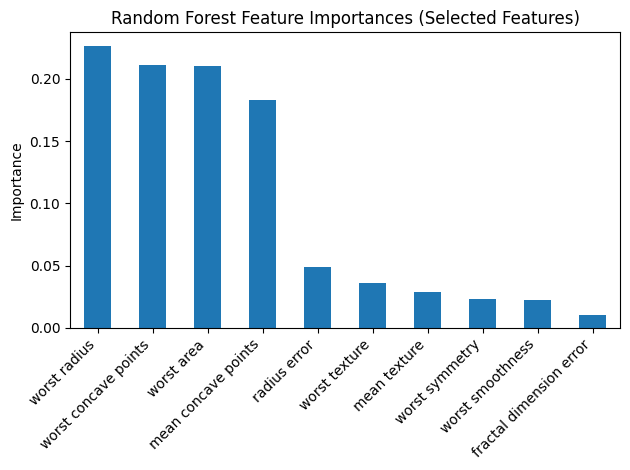

Saved: ../figures/05_rf_feature_importances.png


,importance
worst radius,0.226004
worst concave points,0.210786
worst area,0.210509
mean concave points,0.183098
radius error,0.049089
worst texture,0.036273
mean texture,0.028709
worst symmetry,0.023298
worst smoothness,0.022108
fractal dimension error,0.010126


In [48]:
# Compute and plot model feature importances.
importances = pd.Series(rf_selected.feature_importances_, index=selected_features).sort_values(ascending=False)

plt.figure()
importances.plot(kind="bar")
plt.title("Random Forest Feature Importances (Selected Features)")
plt.ylabel("Importance")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig(FIG_DIR / "05_rf_feature_importances.png", dpi=200, bbox_inches="tight")
plt.show()
print("Saved:", FIG_DIR / "05_rf_feature_importances.png")

display(importances.to_frame("importance"))

In [49]:
# TreeExplainer is efficient and reliable for tree-based models
explainer = shap.TreeExplainer(rf_selected)

# Compute SHAP values for the test set
# Using the same feature matrix that the model sees (selected features)
shap_values = explainer(X_test_sel)

# shap_values is a shap.Explanation object
print("SHAP values shape:", shap_values.values.shape)  # (n_samples, n_features)
print("Base values shape:", np.array(shap_values.base_values).shape)

SHAP values shape: (114, 10, 2)
Base values shape: (114, 2)


## SHAP summary plot

Show global SHAP impacts and save the summary figure.



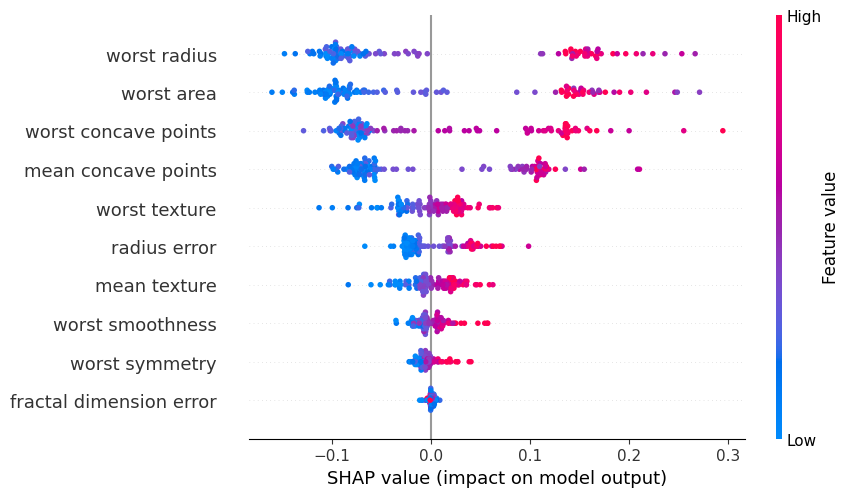

Saved: ../figures/05_shap_summary.png


In [50]:
# Pick which class/output to explain:
# For sklearn breast cancer: 0=malignant, 1=benign
class_idx = 0  # explain probability of class 0 (malignant)

# Handle both 2D and 3D SHAP outputs safely
if shap_values.values.ndim == 3:
    shap_values_plot = shap_values[:, :, class_idx]
else:
    shap_values_plot = shap_values

# Recommended: use shap.plots.beeswarm for Explanation objects
shap.plots.beeswarm(shap_values_plot, max_display=10)

import matplotlib.pyplot as plt

# Create a fresh figure and save it explicitly
fig = plt.figure(figsize=(10, 6))
shap.plots.beeswarm(shap_values_plot, max_display=10, show=False)

fig.tight_layout()
fig.savefig(FIG_DIR / "05_shap_summary.png", dpi=200, bbox_inches="tight")
plt.close(fig)

print("Saved:", FIG_DIR / "05_shap_summary.png")


In [51]:
# Run the next step of the pipeline.
print("Model classes_:", rf_selected.classes_)
print("Explaining class index:", class_idx)

Model classes_: [0 1]
Explaining class index: 0


In [52]:
# Pick one malignant and one benign example from the test set
idx_malignant = y_test[y_test == 0].index[0]
idx_benign = y_test[y_test == 1].index[0]

# Get their row positions inside X_test_sel
pos_malignant = X_test_sel.index.get_loc(idx_malignant)
pos_benign = X_test_sel.index.get_loc(idx_benign)

print("Malignant sample index:", idx_malignant, "position:", pos_malignant)
print("Benign sample index:", idx_benign, "position:", pos_benign)

Malignant sample index: 256 position: 0
Benign sample index: 428 position: 1


## SHAP local explanations

Explain individual predictions with waterfall plots. Save the last generated waterfall figure.



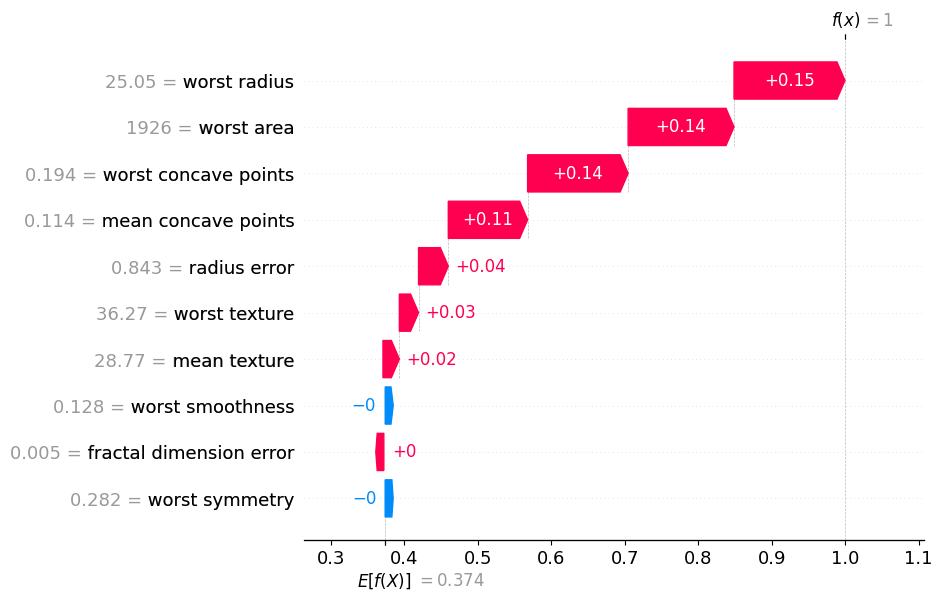

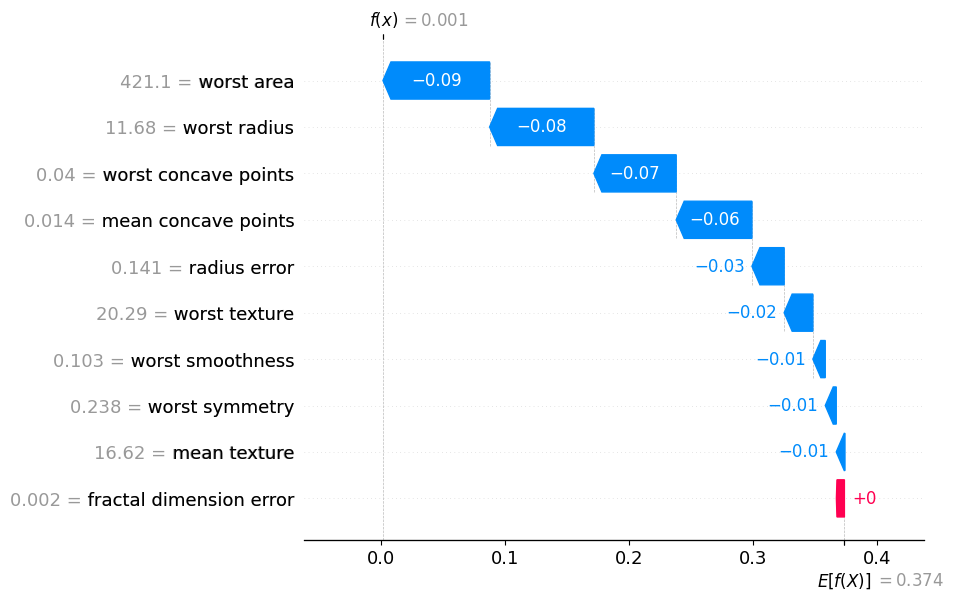

Saved: ../figures/05_shap_waterfall_malignant.png
Saved: ../figures/05_shap_waterfall_benign.png


In [53]:
# Run the next step of the pipeline.
shap.plots.waterfall(shap_values_plot[pos_malignant], max_display=10)
shap.plots.waterfall(shap_values_plot[pos_benign], max_display=10)

import matplotlib.pyplot as plt

# Malignant sample waterfall
fig = plt.figure(figsize=(9, 5))
shap.plots.waterfall(shap_values_plot[pos_malignant], max_display=10, show=False)
fig.tight_layout()
fig.savefig(FIG_DIR / "05_shap_waterfall_malignant.png", dpi=200, bbox_inches="tight")
plt.close(fig)
print("Saved:", FIG_DIR / "05_shap_waterfall_malignant.png")

# Benign sample waterfall
fig = plt.figure(figsize=(9, 5))
shap.plots.waterfall(shap_values_plot[pos_benign], max_display=10, show=False)
fig.tight_layout()
fig.savefig(FIG_DIR / "05_shap_waterfall_benign.png", dpi=200, bbox_inches="tight")
plt.close(fig)
print("Saved:", FIG_DIR / "05_shap_waterfall_benign.png")


## SHAP force plot

Generate an interactive force plot. For the report, take a screenshot and store it in the figures folder.



In [54]:
# Local force plot for one sample (malignant example)
shap.initjs()

# New SHAP API: use shap.plots.force with Explanation objects
shap.plots.force(shap_values_plot[pos_malignant])


## Saved explainability artifacts

Store a small table of the most important features so that the report can reference exact feature names.



In [55]:
import pandas as pd

try:
    imp = pd.DataFrame({"feature": X_train_sel.columns, "importance": rf_selected.feature_importances_})
    imp = imp.sort_values("importance", ascending=False)
    imp.to_csv(OUT_DIR / "05_rf_feature_importances.csv", index=False)
    print("Saved:", OUT_DIR / "05_rf_feature_importances.csv")
    imp.head(10)
except Exception as e:
    print("Could not save feature importances table:", e)


Saved: ../outputs/05_rf_feature_importances.csv
